#Project In Progress
___

# Some installations

In [ ]:
!pip -q install tensorboardX# οκ

In [29]:
!pip -q install ale-py

In [30]:
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py

In [31]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
from tensorboardX import SummaryWriter
import random
from collections import namedtuple,deque




# Let's Start The Project

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [33]:
gym.register_envs(ale_py)

In [34]:
env=gym.make("ALE/SpaceInvaders-v5")

In [35]:
image_of_game=env.reset(seed=41)

In [36]:
frame_dim=image_of_game[0].shape
print(f'The Frame Dimensions Are:{frame_dim}')

The Frame Dimensions Are:(210, 160, 3)


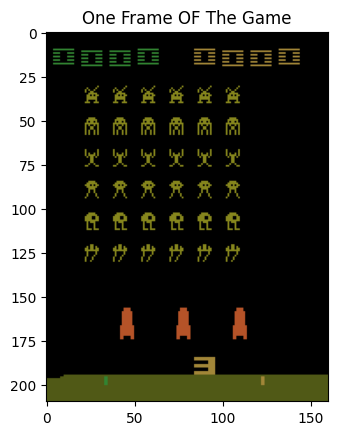

In [37]:
plt.title('One Frame OF The Game')
plt.imshow(image_of_game[0])

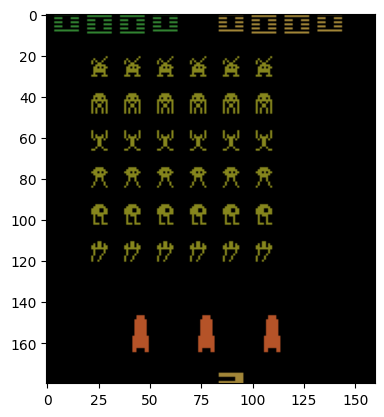

In [38]:
plt.imshow(image_of_game[0][10:190])

In [39]:
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 6



* 0=> NOOP,
* 1=> FIRE,
* 2=> RIGHT,
* 3=> LEFT,
* 4=> RIGHTFIRE,
* 5=> LEFTFIRE

In [40]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [41]:
new_image=env.step(1)

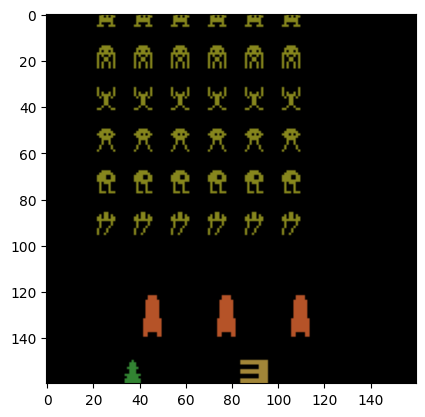

In [42]:
plt.imshow(new_image[0][35:195])


# Make Frames 80x80 float array

In [43]:
def prepro(I):
    """Preprocess 210x160x3 uint8 frame into 80x80 float array"""
    I = I[35:195]  # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1  # everything else (paddles, ball) just set to 1
    return I.astype(np.float32)

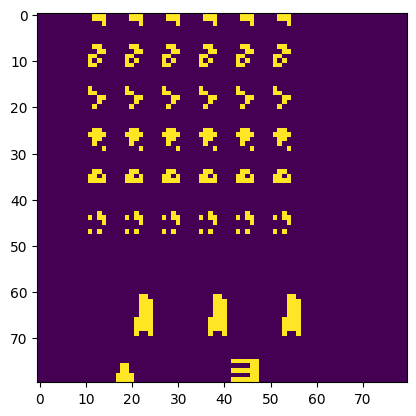

In [44]:
prepro_frame=prepro(new_image[0])
plt.imshow(prepro_frame)
#This is what my model will see

___
# My 1st DQN
___

In [45]:
class DQNet(nn.Module):
    def __init__(self, action_size):
        super(DQNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)


        self.head = nn.Linear(1568, action_size)  # Use action_size here

        # Store episode data
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)

        # Return logits
        return self.head(x)

# ReplayBuffer
___

In [46]:
class ReplayBuffer:
    def __init__(self,buffer_size,batch_size,seed):


        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed=random.seed(seed)

    def add_exp(self, state, action, reward, next_state, done):
        exp = self.experience(state, action, reward, next_state,done)
        self.memory.append(exp)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        # Add unsqueeze(1) to add a channel dimension for the (BATCH_SIZE, 1, H, W) format
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().unsqueeze(1).to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().unsqueeze(1).to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

___
# The Agent
___

In [47]:
LEARNING_RATE=(5e-4)
BUFFER_SIZE=int(1e5)
BATCH_SIZE=64
GAMMA=0.99
TAU=1e-3

In [48]:
class Agent():
  def __init__(self, env, seed):

    self.seed=random.seed(seed)
    self.action_size = env.action_space.n # Initialize action_size
    self.qnet_local=DQNet(self.action_size).to(device) # Pass action_size
    self.qnet_target=DQNet(self.action_size).to(device) # Pass action_size
    self.optimizer=torch.optim.NAdam(self.qnet_local.parameters(),lr=LEARNING_RATE)
    self.memory=ReplayBuffer(BUFFER_SIZE,BATCH_SIZE,seed)
    self.t_step=0

  def step(self,state,action,reward,next_state,done):
    self.memory.add_exp(state,action,reward,next_state,done)
    self.t_step=(self.t_step+1)%4
    if self.t_step==0:
      if len(self.memory)>BATCH_SIZE:
        experiences=self.memory.sample()
        self.learn(experiences,GAMMA)

  def act(self,state,eps=0):
    # Add a channel dimension: from (H, W) to (1, H, W) then unsqueeze for batch (1, 1, H, W)
    state=torch.from_numpy(state).float().unsqueeze(0).unsqueeze(0).to(device)
    self.qnet_local.eval()
    with torch.no_grad():
      action_values=self.qnet_local(state)
    self.qnet_local.train()

    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

  def learn(self,experiences,gamma):
    states,actions,rewards,next_states,dones=experiences
    self.optimizer.zero_grad()
        # Get max predicted Q values (for next states) from target model
    Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1) # Corrected name
        # Compute Q targets for current states
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
    Q_expected = self.qnet_local(states).gather(1, actions) # Corrected name

        # Compute loss
    loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
    loss.backward()
    self.optimizer.step()

        # ------------------- update target network ------------------- #
    self.soft_update(self.qnet_local, self.qnet_target, TAU)

  def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [49]:
agent=Agent(env=env, seed=41)

In [50]:
model = DQNet(num_actions).to(device)

In [54]:
num_episodes = 10000
gamma = 0.99
running_reward = None
reward_history = []
save_every = 100

In [52]:
import os

In [53]:
# Epsilon-greedy policy parameters
eps_start = 1.0
eps_end = 0.001
eps_decay = 0.995 # Decay rate per episode
eps = eps_start

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# Open the file in append mode or create if it doesn't exist. Write header if new.
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(num_episodes):
    # Reset environment
    observation, info = env.reset()

    # Initialize frames for differencing
    # The first 'state' for the agent will be a zero frame (no prior frame to diff with)
    prev_processed_frame = np.zeros_like(prepro(observation)) # Represents prepro(obs_t-1) for t=0

    ep_reward = 0
    step_count = 0

    while True:
        # Current processed frame (prepro(obs_t))
        current_processed_frame = prepro(observation)

        # State for the agent's decision: diff between current and previous processed frame
        state_t = current_processed_frame - prev_processed_frame

        # Select action using the agent's epsilon-greedy policy
        action = agent.act(state_t, eps)

        # Perform action in environment
        observation_next, reward, terminated, truncated, info = env.step(action)

        # Next processed frame (prepro(obs_t+1))
        next_processed_frame = prepro(observation_next)

        # Next state for the agent's experience storage: diff between next and current processed frame
        next_state_t = next_processed_frame - current_processed_frame

        # Store experience and trigger learning (agent.step handles replay buffer and Q-network updates)
        agent.step(state_t, action, reward, next_state_t, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update for next iteration
        prev_processed_frame = current_processed_frame # current_processed_frame becomes previous for next step
        observation = observation_next # observation_next becomes current observation for next step

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')

        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Streaming output truncated to the last 5000 lines.
Episode 1159, Reward:  160.00, Epsilon: 0.0100, Steps: 374
Episode 1160, Reward:  105.00, Epsilon: 0.0100, Steps: 383
Episode 1161, Reward:  125.00, Epsilon: 0.0100, Steps: 392
Episode 1162, Reward:  190.00, Epsilon: 0.0100, Steps: 547
Episode 1163, Reward:  240.00, Epsilon: 0.0100, Steps: 491
Episode 1164, Reward:  300.00, Epsilon: 0.0100, Steps: 677
Episode 1165, Reward:  135.00, Epsilon: 0.0100, Steps: 406
Episode 1166, Reward:  250.00, Epsilon: 0.0100, Steps: 697
Episode 1167, Reward:   70.00, Epsilon: 0.0100, Steps: 289
Episode 1168, Reward:  285.00, Epsilon: 0.0100, Steps: 527
Episode 1169, Reward:  245.00, Epsilon: 0.0100, Steps: 649
Episode 1170, Reward:  125.00, Epsilon: 0.0100, Steps: 366
Episode 1171, Reward:  180.00, Epsilon: 0.0100, Steps: 521
Episode 1172, Reward:  385.00, Epsilon: 0.0100, Steps: 830
Episode 1173, Reward:  175.00, Epsilon: 0.0100, Steps: 555
Episode 1174, Reward:   65.00, Epsilon: 0.0100, Steps: 289
Episo

KeyboardInterrupt: 

#Re_train_1
___

In [60]:
import os

# Define the path to the checkpoint you want to load
# You can change this to any specific checkpoint file (e.g., 'spaceinvaders_checkpoint_800.pt')
# To automatically find the latest checkpoint, you could add logic here.
checkpoint_path = 'spaceinvaders_checkpoint.pt' # Assuming this is the last saved full checkpoint

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load model state dicts
    agent.qnet_local.load_state_dict(checkpoint['model_state_dict'])
    agent.qnet_target.load_state_dict(checkpoint['model_state_dict']) # Target model is often initialized from local

    # Load optimizer state dict
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load other training parameters
    start_episode = checkpoint['episode'] + 1
    eps = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']

    print(f"Resuming training from episode {start_episode} with epsilon {eps:.4f}")
    print(f"Loaded reward history length: {len(reward_history)}")
else:
    print(f"Checkpoint file not found at {checkpoint_path}. Starting new training run.")
    start_episode = 0
    eps = eps_start # From global parameters
    reward_history = []


Resuming training from episode 5901 with epsilon 0.0100
Loaded reward history length: 5901


In [61]:
# Epsilon-greedy policy parameters (eps_start, eps_end, eps_decay are defined globally)

# Define the path for saving mean rewards to a local file
mean_rewards_filepath = 'spaceinvaders_mean_rewards.csv'

# Open the file in append mode or create if it doesn't exist. Write header if new.
# This part assumes a new or clean run if `start_episode` is 0.
# If resuming, you might want to ensure the file is correctly appended to.
if start_episode == 0 and os.path.exists(mean_rewards_filepath):
    os.remove(mean_rewards_filepath)
if not os.path.exists(mean_rewards_filepath):
    with open(mean_rewards_filepath, 'w') as f:
        f.write('episode,mean_reward\n')

# Main training loop
for episode in range(start_episode, num_episodes):
    # Reset environment
    observation, info = env.reset()

    # Initialize frames for differencing
    # The first 'state' for the agent will be a zero frame (no prior frame to diff with)
    prev_processed_frame = np.zeros_like(prepro(observation)) # Represents prepro(obs_t-1) for t=0

    ep_reward = 0
    step_count = 0

    while True:
        # Current processed frame (prepro(obs_t))
        current_processed_frame = prepro(observation)

        # State for the agent's decision: diff between current and previous processed frame
        state_t = current_processed_frame - prev_processed_frame

        # Select action using the agent's epsilon-greedy policy
        action = agent.act(state_t, eps)

        # Perform action in environment
        observation_next, reward, terminated, truncated, info = env.step(action)

        # Next processed frame (prepro(obs_t+1))
        next_processed_frame = prepro(observation_next)

        # Next state for the agent's experience storage: diff between next and current processed frame
        next_state_t = next_processed_frame - current_processed_frame

        # Store experience and trigger learning (agent.step handles replay buffer and Q-network updates)
        agent.step(state_t, action, reward, next_state_t, terminated or truncated)

        ep_reward += reward
        step_count += 1

        # Update for next iteration
        prev_processed_frame = current_processed_frame # current_processed_frame becomes previous for next step
        observation = observation_next # observation_next becomes current observation for next step

        if terminated or truncated:
            break

    reward_history.append(ep_reward)

    # Decay epsilon after each episode
    eps = max(eps_end, eps_decay * eps)

    # Print progress
    if episode % 1 == 0:
        print(f'Episode {episode:4d}, Reward: {ep_reward:7.2f}, Epsilon: {eps:.4f}, Steps: {step_count}')

    if episode % 100 == 0 and episode != 0:
        avg_reward_100_episodes = np.mean(reward_history[-100:])
        print(f'\n--- Episode {episode:4d}, Average reward over last 100 episodes: {avg_reward_100_episodes:7.2f} ---\n')

        # Save the mean reward to a file
        with open(mean_rewards_filepath, 'a') as f:
            f.write(f'{episode},{avg_reward_100_episodes:.2f}\n')
        print(f'Mean reward for episode {episode} saved to {mean_rewards_filepath}')

    # Save checkpoint
    if episode % save_every == 0 and episode > 0:
        torch.save({
            'episode': episode,
            'model_state_dict': agent.qnet_local.state_dict(), # Save agent's local Q-network state
            'optimizer_state_dict': agent.optimizer.state_dict(), # Save agent's optimizer state
            'reward_history': reward_history,
            'epsilon': eps
        }, f'spaceinvaders_checkpoint_{episode}.pt')
        print(f'Checkpoint saved at episode {episode}')

    # Check if solved (condition might need tuning for Space Invaders)
    if len(reward_history) >= 100 and np.mean(reward_history[-100:]) > 500: # Example condition, adjust as needed
        print(f"\nSolved! Running average reward over 100 episodes: {np.mean(reward_history[-100:]):.2f}\n")
        torch.save(agent.qnet_local.state_dict(), 'spaceinvaders_solved.pt')
        break

env.close()
print("Training complete!")

Episode 5901, Reward:  350.00, Epsilon: 0.0100, Steps: 759
Episode 5902, Reward:   20.00, Epsilon: 0.0100, Steps: 247
Episode 5903, Reward:  175.00, Epsilon: 0.0100, Steps: 625
Episode 5904, Reward:  160.00, Epsilon: 0.0100, Steps: 390
Episode 5905, Reward:   40.00, Epsilon: 0.0100, Steps: 258
Episode 5906, Reward:  105.00, Epsilon: 0.0100, Steps: 295
Episode 5907, Reward:  265.00, Epsilon: 0.0100, Steps: 589
Episode 5908, Reward:  830.00, Epsilon: 0.0100, Steps: 939
Episode 5909, Reward:  165.00, Epsilon: 0.0100, Steps: 472
Episode 5910, Reward:  175.00, Epsilon: 0.0100, Steps: 510
Episode 5911, Reward:  765.00, Epsilon: 0.0100, Steps: 1285
Episode 5912, Reward:   85.00, Epsilon: 0.0100, Steps: 393
Episode 5913, Reward:  105.00, Epsilon: 0.0100, Steps: 302
Episode 5914, Reward:  155.00, Epsilon: 0.0100, Steps: 361
Episode 5915, Reward:   10.00, Epsilon: 0.0100, Steps: 288
Episode 5916, Reward:  300.00, Epsilon: 0.0100, Steps: 755
Episode 5917, Reward:  340.00, Epsilon: 0.0100, Steps: 

KeyboardInterrupt: 

#Now, let's run an episode with the loaded weights to see the agent play. We will set epsilon to 0 to make the agent act greedily based on its learned policy.

In [ ]:
# Path to your saved model weights (e.g., 'spaceinvaders_solved.pt' or a specific checkpoint)
checkpoint_path = 'spaceinvaders_solved.pt'

# Load the state dictionary
# Ensure the model architecture (DQNet) is defined and agent is initialized before this step
agent.qnet_local.load_state_dict(torch.load(checkpoint_path))
agent.qnet_local.eval() # Set the model to evaluation mode

print(f"Model weights loaded from {checkpoint_path}")

In [ ]:
eval_episodes = 1 # Number of episodes to run for evaluation
eps_eval = 0.0 # Set epsilon to 0 for greedy action selection

# For visualizing the gameplay if needed, you might want to render the environment.
# env = gym.make("ALE/SpaceInvaders-v5", render_mode="human") # Uncomment for visual display if running locally

for episode in range(eval_episodes):
    observation, info = env.reset()
    prev_processed_frame = np.zeros_like(prepro(observation))
    ep_reward = 0
    step_count = 0

    while True:
        current_processed_frame = prepro(observation)
        state_t = current_processed_frame - prev_processed_frame

        # Select action using the agent's greedy policy (eps_eval = 0)
        action = agent.act(state_t, eps_eval)

        observation_next, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        step_count += 1

        prev_processed_frame = current_processed_frame
        observation = observation_next

        if terminated or truncated:
            break

    print(f'Evaluation Episode {episode:4d}, Reward: {ep_reward:7.2f}, Steps: {step_count}')

env.close()
print("Evaluation complete!")